In [1]:
import torch
from torchvision.transforms import v2 as transforms

import lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint

from keyrover import *
from keyrover.vision import *
from keyrover.datasets.binary_dataset import *

device

'mps'

In [2]:
SIZE = (480, 640)

train_dataset, valid_dataset, test_dataset = KeyboardBinaryMaskDataset.load("v4", n=10, size=SIZE)
len(train_dataset), len(valid_dataset), len(test_dataset)

  0%|          | 0/8 [00:00<?, ?it/s]

Error decoding JSON from /Users/bhavyemathur/Library/Application Support/Ultralytics/settings.json. Starting with an empty dictionary.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/bhavyemathur/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Error decoding JSON from /Users/bhavyemathur/Library/Application Support/Ultralytics/settings.json. Starting with an empty dictionary.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/bhavyemathur/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


  0%|          | 0/8 [00:00<?, ?it/s]

Error decoding JSON from /Users/bhavyemathur/Library/Application Support/Ultralytics/settings.json. Starting with an empty dictionary.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/bhavyemathur/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


(8, 1, 1)

<class 'torch.Tensor'> (torch.float32, shape=torch.Size([3, 480, 640]))
        Min: -1.2803890705108643
        Max: 2.1832633018493652
        Mean: 0.1203702762722969


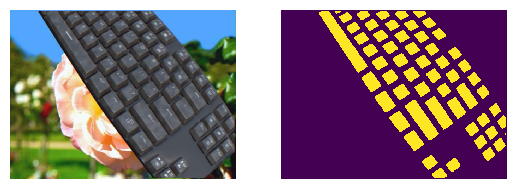

In [35]:
# train_dataset.set_transforms([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomAffine(degrees=30, shear=30, translate=(0.25, 0.25)),
    # transforms.RandomPerspective(distortion_scale=0.25, p=0.5),
    # transforms.RandomErasing(p=0.5),
# ])

train_dataset.set_input_augmentations([
    # transforms.RandomChannelPermutation(),
    # transforms.GaussianNoise(sigma=0.1, clip=True),
    transforms.RandomApply([transforms.GaussianNoise(sigma=0.1, clip=False)], p=0.5),
], norm_params="default")

img, mask = train_dataset.random_img()
imshow(img, mask)

describe(img)

<Axes: >

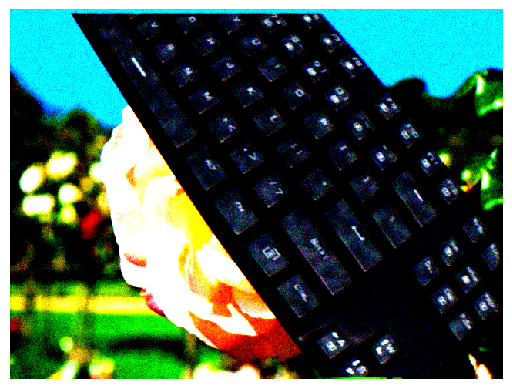

In [38]:
imshow(transforms.GaussianNoise(sigma=0.1)(img))

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

dl_kwargs = {"batch_size": BATCH_SIZE, "num_workers": 2, "persistent_workers": True, "pin_memory": True}

train_dataloader = DataLoader(train_dataset, **dl_kwargs, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, **dl_kwargs)
test_dataloader = DataLoader(test_dataset, **dl_kwargs)

In [ ]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

In [ ]:
ARCH = "unet"
BACKBONE = "timm-regnetx_002"

LEARNING_RATE = 2e-4

wandb.finish()
model = BinarySegmentationModel(ARCH, BACKBONE, in_channels=3, out_classes=1, encoder_weights="imagenet", lr=LEARNING_RATE)
model

In [ ]:
summarize(model)

In [ ]:
EPOCHS = 100

PROFILE = False
profiler = "advanced" if PROFILE else None

logger = WandbLogger(project="mrover-keyboard-region-segmentation")
# logger.watch(model, log="all", log_freq=len(train_dataloader))

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(log_every_n_steps=1, logger=logger, max_time="00:08:00:00",
                     callbacks=[checkpoint_callback], profiler=profiler)
wandb.define_metric(f"val_loss", summary="min")
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

In [ ]:
torch.save(model.state_dict(), f"models/binary_segmentation/{wandb.run.name}-{ARCH}-{BACKBONE}.pt")